## 1. Setup e Import

In [1]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import yaml
import pandas as pd
import random
import time
from PIL import Image
from scipy.spatial.transform import Rotation

sys.path.insert(0, str(Path.cwd().parent))
from config import Config

# Import ENTRAMBI i modelli
from models.pose_estimator_baseline import PoseEstimatorBaseline
from models.pose_estimator_endtoend import PoseEstimator as PoseEstimatorEndToEnd
from models.yolo_detector import YOLODetector
from utils.pinhole import load_camera_intrinsics, compute_translation_pinhole
from utils.transforms import crop_image_from_bbox, get_pose_transforms

project_root = Config.PROJECT_ROOT
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

%matplotlib inline

print(f"✅ Setup completato (COMPARISON MODE)")
print(f"📂 Project root: {project_root}")
print(f"🎯 Dataset: LineMOD")
print(f"🖥️  Device: {Config.DEVICE}")
print(f"\n📊 Comparison:")
print(f"   [1] Baseline:  Pinhole + ResNet Rotation")
print(f"   [2] Extension: End-to-End ResNet (Translation + Rotation)")

Cache Strategy: partial
Numworkers set to 0
Numworkers set to 0
✅ Setup completato (COMPARISON MODE)
📂 Project root: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation
🎯 Dataset: LineMOD
🖥️  Device: mps

📊 Comparison:
   [1] Baseline:  Pinhole + ResNet Rotation
   [2] Extension: End-to-End ResNet (Translation + Rotation)


## 2. Carica TUTTI i Modelli

In [ ]:
# ====== CARICAMENTO MODELLI PER COMPARISON ======

print("=" * 80)
print("📦 CARICAMENTO MODELLI PER COMPARISON")
print("=" * 80)

# 1. YOLO (comune per entrambi)
print("\n1️⃣  YOLO Detector (comune)")
YOLO_MODEL = f'yolo_train{Config.YOLO_EPOCHS}'
yolo_weights = Config.CHECKPOINT_DIR / 'yolo' / YOLO_MODEL / 'weights' / 'best.pt'

if yolo_weights.exists():
    yolo_detector = YOLODetector(str(yolo_weights), num_classes=Config.NUM_CLASSES)
    print(f"   ✅ Caricato: {yolo_weights.name}")
else:
    print(f"   ❌ Non trovato: {yolo_weights}")
    yolo_detector = None

# 2. Baseline Model
print("\n2️⃣  Baseline Model (Pinhole + ResNet Rotation)")
BASELINE_MODEL = "pose_stable_train100"
baseline_checkpoint = project_root / 'checkpoints' / 'pose' / BASELINE_MODEL / 'weights' / 'best.pt'

model_baseline = PoseEstimatorBaseline(
    pretrained=True,
    dropout=Config.POSE_DROPOUT,
    freeze_backbone=False
).to(Config.DEVICE)

if baseline_checkpoint.exists():
    checkpoint = torch.load(baseline_checkpoint, map_location=Config.DEVICE)
    model_baseline.load_state_dict(checkpoint['model_state_dict'])
    print(f"   ✅ Trained checkpoint: {BASELINE_MODEL}")
else:
    print(f"   ❌ Non trovato: pretrained only (no trained checkpoint)")
model_baseline.eval()

# 3. Extension Model (End-to-End)
print("\n3️⃣  Extension Model (End-to-End ResNet)")
ENDTOEND_MODEL = "pose_stable_train100"
endtoend_checkpoint = project_root / 'checkpoints' / 'pose' / ENDTOEND_MODEL / 'weights' / 'best.pt'

model_endtoend = PoseEstimatorEndToEnd(
    pretrained=True,
    dropout=Config.POSE_DROPOUT,
    freeze_backbone=False
).to(Config.DEVICE)

if endtoend_checkpoint.exists():
    checkpoint = torch.load(endtoend_checkpoint, map_location=Config.DEVICE)
    model_endtoend.load_state_dict(checkpoint['model_state_dict'])
    print(f"   ✅ Trained checkpoint: {ENDTOEND_MODEL}")
else:
    print(f"   ❌ Non trovato: {endtoend_checkpoint}")
    print(f"   Usando modello non trained")
model_endtoend.eval()

# Riepilogo
print("\n" + "=" * 80)
print("📋 RIEPILOGO CARICAMENTO")
print("=" * 80)
print(f"YOLO:      {'✅' if yolo_detector is not None else '❌'}")
print(f"Baseline:  ✅ ({BASELINE_MODEL})")
print(f"Extension: ✅ ({ENDTOEND_MODEL})")
print("\n🚀 Pronto per comparison!")
print("=" * 80)

📦 CARICAMENTO MODELLI PER COMPARISON

1️⃣  YOLO Detector (comune)
✅ Loading custom weights from: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/yolo/yolo_train20/weights/best.pt
   ✅ Caricato: best.pt

2️⃣  Baseline Model (Pinhole + ResNet Rotation)


/Users/nicolotermine/Library/Caches/pypoetry/virtualenvs/polito-aml-6d-pose-estimation-LevBIKLF-py3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/nicolotermine/Library/Caches/pypoetry/virtualenvs/polito-aml-6d-pose-estimation-LevBIKLF-py3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ PoseEstimatorBaseline initialized (BASELINE MODEL)
   Backbone: resnet50 (pretrained=True, frozen=False)
   Feature dim: 2048
   Output: 4 values (quaternion only)
   Translation: Computed with Pinhole Camera Model (NOT learned)
   Dropout: 0.5


RuntimeError: Error(s) in loading state_dict for PoseEstimatorBaseline:
	Missing key(s) in state_dict: "quaternion_head.0.weight", "quaternion_head.0.bias", "quaternion_head.1.weight", "quaternion_head.1.bias", "quaternion_head.1.running_mean", "quaternion_head.1.running_var", "quaternion_head.4.weight", "quaternion_head.4.bias", "quaternion_head.5.weight", "quaternion_head.5.bias", "quaternion_head.5.running_mean", "quaternion_head.5.running_var", "quaternion_head.8.weight", "quaternion_head.8.bias". 
	Unexpected key(s) in state_dict: "pose_head.0.weight", "pose_head.0.bias", "pose_head.1.weight", "pose_head.1.bias", "pose_head.1.running_mean", "pose_head.1.running_var", "pose_head.1.num_batches_tracked", "pose_head.4.weight", "pose_head.4.bias", "pose_head.5.weight", "pose_head.5.bias", "pose_head.5.running_mean", "pose_head.5.running_var", "pose_head.5.num_batches_tracked", "pose_head.8.weight", "pose_head.8.bias". 

## 3. Test Comparativo su Multiple Immagini

🔬 TEST COMPARATIVO: Baseline vs Extension

📸 Testing su 50 immagini casuali...



Processing: 100%|██████████| 50/50 [00:42<00:00,  1.19it/s]


📊 STATISTICHE COMPARATIVE

📸 Dataset:
   Immagini testate: 50
   Baseline success: 50 (100.0%)
   Extension success: 50 (100.0%)

📋 TABELLA COMPARATIVA
                         Metrica Baseline (Pinhole+ResNet) Extension (End-to-End)
  Translation Error (mm) - Media                     43.37                 899.34
Translation Error (mm) - Mediana                     28.77                 901.00
    Translation Error (mm) - Min                      5.90                 694.17
    Translation Error (mm) - Max                    404.31                1257.28
    Rotation Error (deg) - Media                    116.92                 115.05
  Rotation Error (deg) - Mediana                    114.09                 118.15
      Rotation Error (deg) - Min                     45.04                  43.68
      Rotation Error (deg) - Max                    172.44                 179.26
     Inference Time (ms) - Media                    230.90                   6.96
          Translation < 50m


/var/folders/sm/2j33cq497xsfv6ld4q_3wtq80000gn/T/ipykernel_24652/253034675.py:225: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot([baseline_results['trans_errors'], extension_results['trans_errors']],
/var/folders/sm/2j33cq497xsfv6ld4q_3wtq80000gn/T/ipykernel_24652/253034675.py:232: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot([baseline_results['rot_errors'], extension_results['rot_errors']],


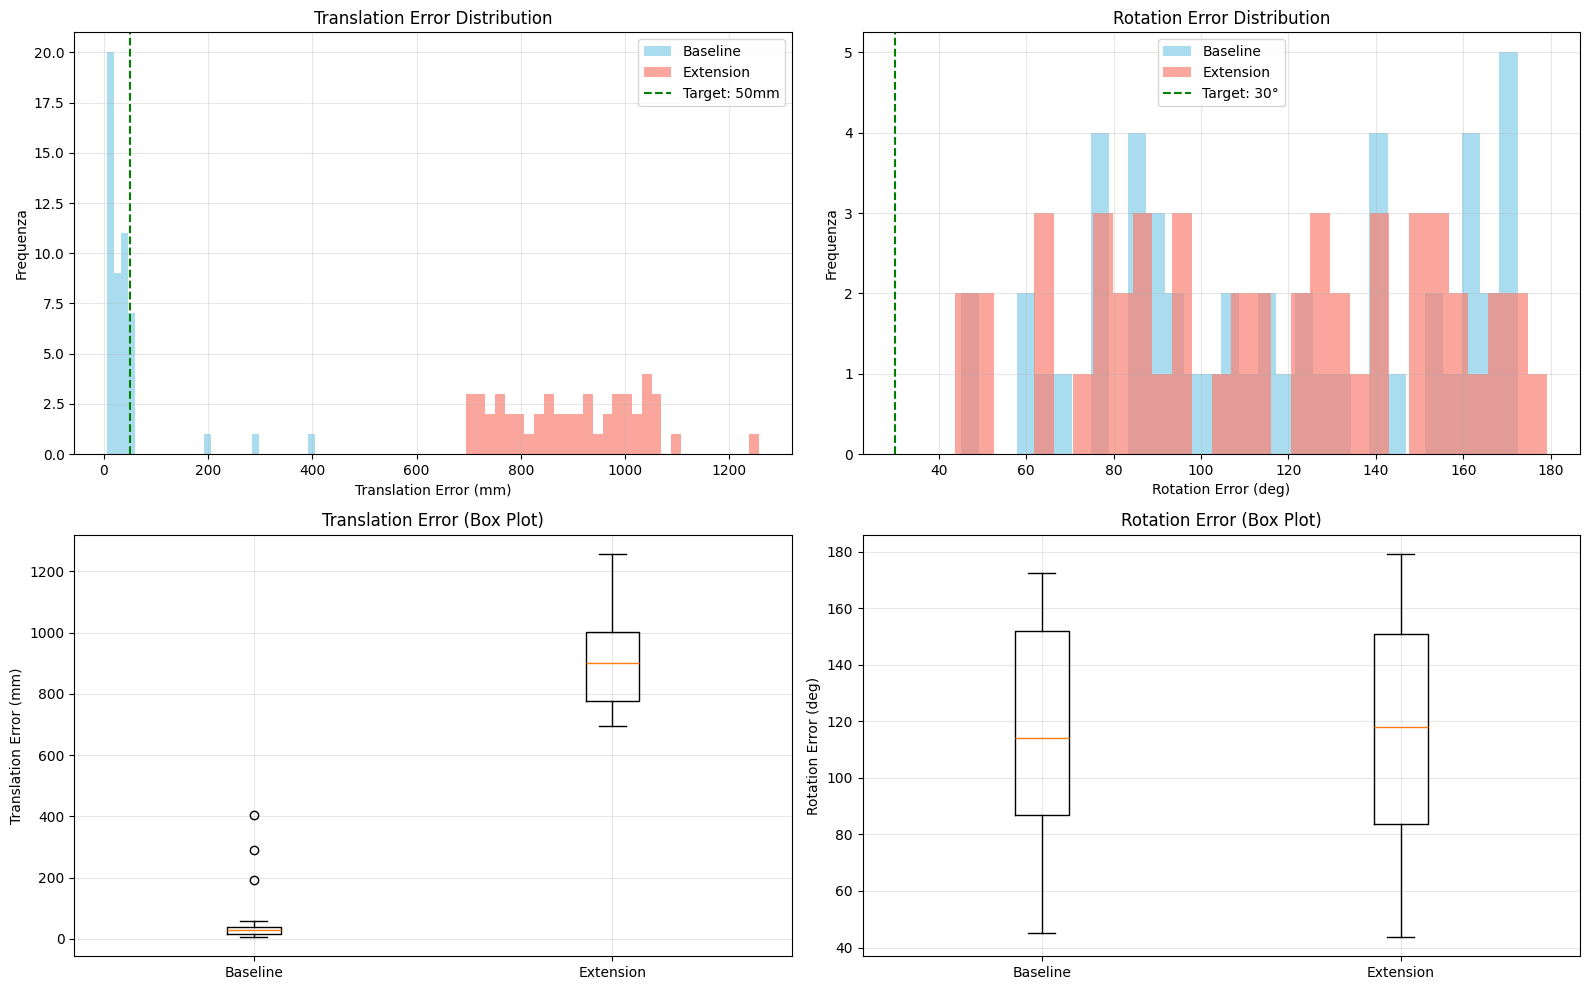


🏆 WINNER ANALYSIS
Translation Accuracy: ✅ Baseline (43.37mm)
Rotation Accuracy:    ✅ Extension (115.05°)
Inference Speed:      ✅ Extension (6.96ms)

💡 Conclusioni:
   • Baseline ha translation 95.2% più accurata (Pinhole è geometrico!)
   • Rotation baseline necessita più training (116.9°)

📌 Raccomandazione:
   ⚠️  Allena baseline più a lungo prima di presentare


In [3]:
# ====== TEST COMPARATIVO ======

print("=" * 80)
print("🔬 TEST COMPARATIVO: Baseline vs Extension")
print("=" * 80)

if yolo_detector is None:
    print("❌ YOLO detector non disponibile")
else:
    NUM_TEST_IMAGES = 50  # Aumenta per statistiche più robuste
    
    # Risultati per baseline
    baseline_results = {
        'trans_errors': [],
        'rot_errors': [],
        'inference_times': [],
        'success': 0,
        'failed_yolo': 0,
        'failed_pinhole': 0
    }
    
    # Risultati per extension
    extension_results = {
        'trans_errors': [],
        'rot_errors': [],
        'inference_times': [],
        'success': 0,
        'failed_yolo': 0
    }
    
    # Carica lista immagini
    data_root = Config.LINEMOD_ROOT / 'data'
    available_images = []
    
    for obj_folder in sorted(data_root.iterdir()):
        if obj_folder.is_dir() and obj_folder.name.isdigit():
            rgb_folder = obj_folder / 'rgb'
            if rgb_folder.exists():
                available_images.extend(list(rgb_folder.glob('*.png')))
    
    print(f"\n📸 Testing su {NUM_TEST_IMAGES} immagini casuali...\n")
    
    pose_transforms = get_pose_transforms(train=False)
    test_images = random.sample(available_images, min(NUM_TEST_IMAGES, len(available_images)))
    
    for test_img_path in tqdm(test_images, desc="Processing"):
        test_image_RGB = np.array(Image.open(test_img_path).convert('RGB'))
        test_image_BGR = test_image_RGB[..., ::-1]
        obj_id = test_img_path.parent.parent.name
        img_name = test_img_path.name
        img_id = int(img_name.split('.')[0])
        
        # Carica GT
        gt_path = data_root / obj_id / 'gt.yml'
        if not gt_path.exists():
            continue
        
        with open(gt_path, 'r') as f:
            gt_data = yaml.safe_load(f)
        
        if img_id not in gt_data or len(gt_data[img_id]) == 0:
            continue
        
        gt_pose = gt_data[img_id][0]
        gt_R = np.array(gt_pose['cam_R_m2c']).reshape(3, 3)
        gt_t = np.array(gt_pose['cam_t_m2c']).flatten()
        
        # YOLO detection (comune)
        detections = yolo_detector.detect_objects(test_image_BGR, conf_threshold=0.3)
        
        if len(detections) == 0:
            baseline_results['failed_yolo'] += 1
            extension_results['failed_yolo'] += 1
            continue
        
        bbox = detections[0]['bbox']
        
        # Crop comune
        cropped = crop_image_from_bbox(
            test_image_RGB, bbox,
            margin=Config.POSE_CROP_MARGIN,
            output_size=(Config.POSE_IMAGE_SIZE, Config.POSE_IMAGE_SIZE)
        )
        cropped_tensor = pose_transforms(cropped).unsqueeze(0).to(Config.DEVICE)
        
        # ============ TEST BASELINE ============
        try:
            start_time = time.time()
            
            # Pinhole translation
            depth_path = data_root / obj_id / 'depth' / img_name
            camera_intrinsics = load_camera_intrinsics(gt_path)
            pred_trans_baseline = compute_translation_pinhole(bbox, depth_path, camera_intrinsics)
            
            # ResNet rotation
            with torch.no_grad():
                pred_quat_baseline = model_baseline(cropped_tensor).cpu().numpy()[0]
            
            inference_time_baseline = time.time() - start_time
            
            # Errori
            trans_error_baseline = np.linalg.norm(pred_trans_baseline - gt_t)
            pred_R_baseline = Rotation.from_quat([pred_quat_baseline[1], pred_quat_baseline[2], 
                                                   pred_quat_baseline[3], pred_quat_baseline[0]]).as_matrix()
            R_error = pred_R_baseline.T @ gt_R
            rot_error_baseline = np.degrees(np.arccos(np.clip((np.trace(R_error) - 1) / 2, -1, 1)))
            
            baseline_results['trans_errors'].append(trans_error_baseline)
            baseline_results['rot_errors'].append(rot_error_baseline)
            baseline_results['inference_times'].append(inference_time_baseline)
            baseline_results['success'] += 1
            
        except Exception:
            baseline_results['failed_pinhole'] += 1
        
        # ============ TEST EXTENSION ============
        start_time = time.time()
        
        with torch.no_grad():
            pred_quat_ext, pred_trans_ext = model_endtoend(cropped_tensor)
        
        pred_quat_ext = pred_quat_ext.cpu().numpy()[0]
        pred_trans_ext = pred_trans_ext.cpu().numpy()[0] * 1000.0  # m → mm
        
        inference_time_ext = time.time() - start_time
        
        # Errori
        trans_error_ext = np.linalg.norm(pred_trans_ext - gt_t)
        pred_R_ext = Rotation.from_quat([pred_quat_ext[1], pred_quat_ext[2], 
                                          pred_quat_ext[3], pred_quat_ext[0]]).as_matrix()
        R_error_ext = pred_R_ext.T @ gt_R
        rot_error_ext = np.degrees(np.arccos(np.clip((np.trace(R_error_ext) - 1) / 2, -1, 1)))
        
        extension_results['trans_errors'].append(trans_error_ext)
        extension_results['rot_errors'].append(rot_error_ext)
        extension_results['inference_times'].append(inference_time_ext)
        extension_results['success'] += 1
    
    # ============ STAMPA STATISTICHE ============
    print("\n" + "=" * 80)
    print("📊 STATISTICHE COMPARATIVE")
    print("=" * 80)
    
    print(f"\n📸 Dataset:")
    print(f"   Immagini testate: {NUM_TEST_IMAGES}")
    print(f"   Baseline success: {baseline_results['success']} ({100*baseline_results['success']/NUM_TEST_IMAGES:.1f}%)")
    print(f"   Extension success: {extension_results['success']} ({100*extension_results['success']/NUM_TEST_IMAGES:.1f}%)")
    
    # Tabella comparativa
    if baseline_results['success'] > 0 and extension_results['success'] > 0:
        comparison_table = pd.DataFrame({
            'Metrica': [
                'Translation Error (mm) - Media',
                'Translation Error (mm) - Mediana',
                'Translation Error (mm) - Min',
                'Translation Error (mm) - Max',
                'Rotation Error (deg) - Media',
                'Rotation Error (deg) - Mediana',
                'Rotation Error (deg) - Min',
                'Rotation Error (deg) - Max',
                'Inference Time (ms) - Media',
                'Translation < 50mm (%)',
                'Rotation < 30° (%)'
            ],
            'Baseline (Pinhole+ResNet)': [
                f"{np.mean(baseline_results['trans_errors']):.2f}",
                f"{np.median(baseline_results['trans_errors']):.2f}",
                f"{np.min(baseline_results['trans_errors']):.2f}",
                f"{np.max(baseline_results['trans_errors']):.2f}",
                f"{np.mean(baseline_results['rot_errors']):.2f}",
                f"{np.median(baseline_results['rot_errors']):.2f}",
                f"{np.min(baseline_results['rot_errors']):.2f}",
                f"{np.max(baseline_results['rot_errors']):.2f}",
                f"{np.mean(baseline_results['inference_times'])*1000:.2f}",
                f"{100*sum(e<50 for e in baseline_results['trans_errors'])/len(baseline_results['trans_errors']):.1f}",
                f"{100*sum(e<30 for e in baseline_results['rot_errors'])/len(baseline_results['rot_errors']):.1f}"
            ],
            'Extension (End-to-End)': [
                f"{np.mean(extension_results['trans_errors']):.2f}",
                f"{np.median(extension_results['trans_errors']):.2f}",
                f"{np.min(extension_results['trans_errors']):.2f}",
                f"{np.max(extension_results['trans_errors']):.2f}",
                f"{np.mean(extension_results['rot_errors']):.2f}",
                f"{np.median(extension_results['rot_errors']):.2f}",
                f"{np.min(extension_results['rot_errors']):.2f}",
                f"{np.max(extension_results['rot_errors']):.2f}",
                f"{np.mean(extension_results['inference_times'])*1000:.2f}",
                f"{100*sum(e<50 for e in extension_results['trans_errors'])/len(extension_results['trans_errors']):.1f}",
                f"{100*sum(e<30 for e in extension_results['rot_errors'])/len(extension_results['rot_errors']):.1f}"
            ]
        })
        
        print("\n" + "=" * 120)
        print("📋 TABELLA COMPARATIVA")
        print("=" * 120)
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', None)
        print(comparison_table.to_string(index=False))
        print("=" * 120)
        
        # Grafici side-by-side
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        
        # Translation errors
        axes[0, 0].hist(baseline_results['trans_errors'], bins=30, alpha=0.7, label='Baseline', color='skyblue')
        axes[0, 0].hist(extension_results['trans_errors'], bins=30, alpha=0.7, label='Extension', color='salmon')
        axes[0, 0].axvline(50, color='green', linestyle='--', label='Target: 50mm')
        axes[0, 0].set_xlabel('Translation Error (mm)')
        axes[0, 0].set_ylabel('Frequenza')
        axes[0, 0].set_title('Translation Error Distribution')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Rotation errors
        axes[0, 1].hist(baseline_results['rot_errors'], bins=30, alpha=0.7, label='Baseline', color='skyblue')
        axes[0, 1].hist(extension_results['rot_errors'], bins=30, alpha=0.7, label='Extension', color='salmon')
        axes[0, 1].axvline(30, color='green', linestyle='--', label='Target: 30°')
        axes[0, 1].set_xlabel('Rotation Error (deg)')
        axes[0, 1].set_ylabel('Frequenza')
        axes[0, 1].set_title('Rotation Error Distribution')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # Box plots translation
        axes[1, 0].boxplot([baseline_results['trans_errors'], extension_results['trans_errors']], 
                          labels=['Baseline', 'Extension'])
        axes[1, 0].set_ylabel('Translation Error (mm)')
        axes[1, 0].set_title('Translation Error (Box Plot)')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Box plots rotation
        axes[1, 1].boxplot([baseline_results['rot_errors'], extension_results['rot_errors']], 
                          labels=['Baseline', 'Extension'])
        axes[1, 1].set_ylabel('Rotation Error (deg)')
        axes[1, 1].set_title('Rotation Error (Box Plot)')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Winner analysis
        print("\n" + "=" * 80)
        print("🏆 WINNER ANALYSIS")
        print("=" * 80)
        
        baseline_trans_avg = np.mean(baseline_results['trans_errors'])
        extension_trans_avg = np.mean(extension_results['trans_errors'])
        baseline_rot_avg = np.mean(baseline_results['rot_errors'])
        extension_rot_avg = np.mean(extension_results['rot_errors'])
        baseline_time_avg = np.mean(baseline_results['inference_times']) * 1000
        extension_time_avg = np.mean(extension_results['inference_times']) * 1000
        
        trans_winner = "Baseline" if baseline_trans_avg < extension_trans_avg else "Extension"
        rot_winner = "Baseline" if baseline_rot_avg < extension_rot_avg else "Extension"
        time_winner = "Baseline" if baseline_time_avg < extension_time_avg else "Extension"
        
        print(f"Translation Accuracy: ✅ {trans_winner} ({min(baseline_trans_avg, extension_trans_avg):.2f}mm)")
        print(f"Rotation Accuracy:    ✅ {rot_winner} ({min(baseline_rot_avg, extension_rot_avg):.2f}°)")
        print(f"Inference Speed:      ✅ {time_winner} ({min(baseline_time_avg, extension_time_avg):.2f}ms)")
        
        print("\n💡 Conclusioni:")
        if trans_winner == "Baseline":
            improvement = ((extension_trans_avg - baseline_trans_avg) / extension_trans_avg) * 100
            print(f"   • Baseline ha translation {improvement:.1f}% più accurata (Pinhole è geometrico!)")
        else:
            print(f"   • Extension sorprendentemente accurata su translation")
        
        if baseline_rot_avg < 40:
            print(f"   • Rotation baseline è accettabile ({baseline_rot_avg:.1f}°)")
        else:
            print(f"   • Rotation baseline necessita più training ({baseline_rot_avg:.1f}°)")
        
        print("\n📌 Raccomandazione:")
        if baseline_trans_avg < 30 and baseline_rot_avg < 50:
            print("   ✅ Usa BASELINE per presentazione (conforme alle specifiche)")
        else:
            print("   ⚠️  Allena baseline più a lungo prima di presentare")
    
    print("=" * 80)

## 4. Confronto Qualitativo (Visualizzazioni Side-by-Side)

🎨 CONFRONTO QUALITATIVO: Visualizzazione Side-by-Side

📷 Test image: data/08/rgb/0259.png



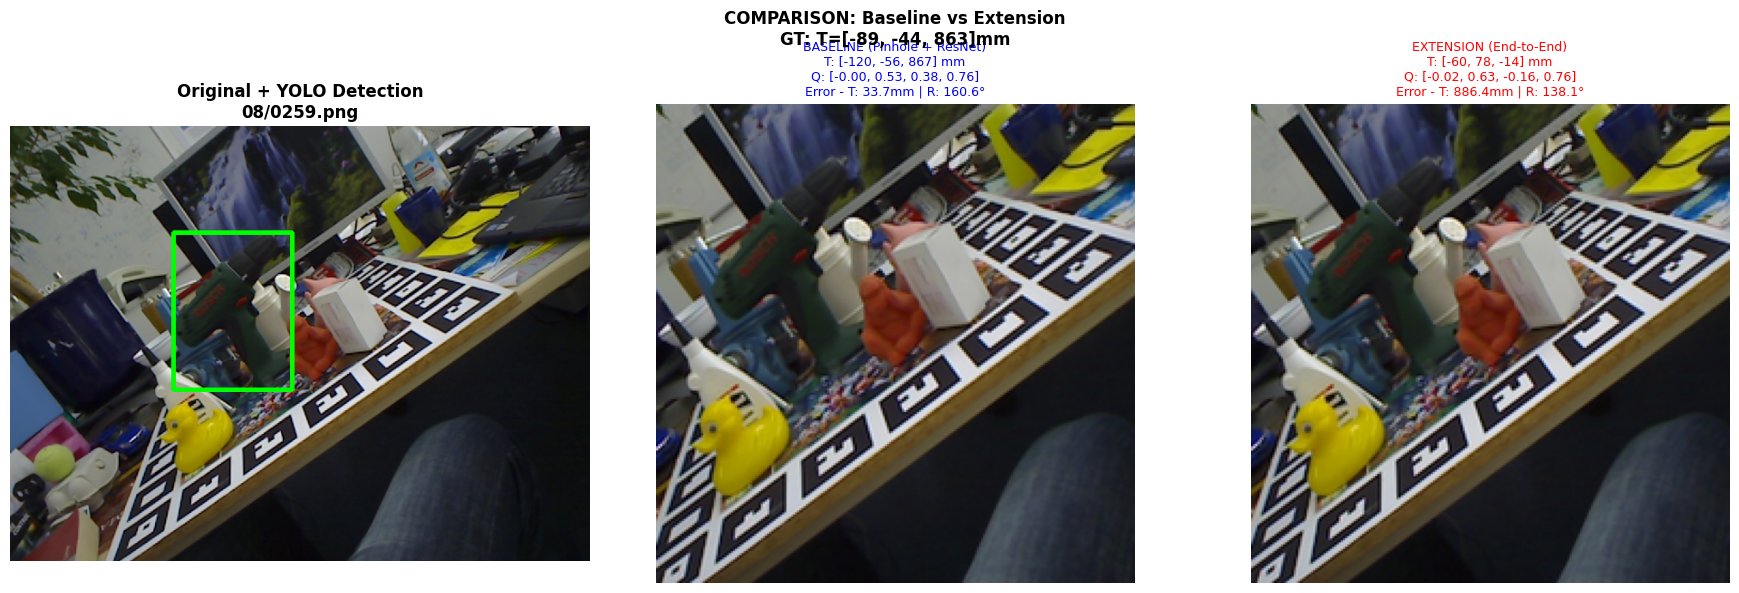


📊 Confronto diretto:
   Translation Error: Baseline 33.7mm vs Extension 886.4mm
   Rotation Error:    Baseline 160.6° vs Extension 138.1°
   ✅ Baseline vince su translation (96.2% meglio)

=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
✅ COMPARISON COMPLETATO!


In [4]:
# ====== CONFRONTO QUALITATIVO ======

print("=" * 80)
print("🎨 CONFRONTO QUALITATIVO: Visualizzazione Side-by-Side")
print("=" * 80)

# Seleziona un'immagine casuale per visualizzazione
if yolo_detector is not None and len(available_images) > 0:
    test_img_path = random.choice(available_images)
    test_image_RGB = np.array(Image.open(test_img_path).convert('RGB'))
    test_image_BGR = test_image_RGB[..., ::-1]
    obj_id = test_img_path.parent.parent.name
    img_name = test_img_path.name
    img_id = int(img_name.split('.')[0])
    
    print(f"\n📷 Test image: data/{obj_id}/rgb/{img_name}\n")
    
    # Ground truth
    gt_path = data_root / obj_id / 'gt.yml'
    with open(gt_path, 'r') as f:
        gt_data = yaml.safe_load(f)
    
    if img_id in gt_data and len(gt_data[img_id]) > 0:
        gt_pose = gt_data[img_id][0]
        gt_R = np.array(gt_pose['cam_R_m2c']).reshape(3, 3)
        gt_t = np.array(gt_pose['cam_t_m2c']).flatten()
        
        # Detection
        detections = yolo_detector.detect_objects(test_image_BGR, conf_threshold=0.3)
        
        if len(detections) > 0:
            bbox = detections[0]['bbox']
            
            # Crop
            cropped = crop_image_from_bbox(
                test_image_RGB, bbox,
                margin=Config.POSE_CROP_MARGIN,
                output_size=(Config.POSE_IMAGE_SIZE, Config.POSE_IMAGE_SIZE)
            )
            cropped_tensor = pose_transforms(cropped).unsqueeze(0).to(Config.DEVICE)
            
            # Baseline prediction
            depth_path = data_root / obj_id / 'depth' / img_name
            camera_intrinsics = load_camera_intrinsics(gt_path)
            
            try:
                pred_trans_baseline = compute_translation_pinhole(bbox, depth_path, camera_intrinsics)
                with torch.no_grad():
                    pred_quat_baseline = model_baseline(cropped_tensor).cpu().numpy()[0]
                
                trans_err_baseline = np.linalg.norm(pred_trans_baseline - gt_t)
                pred_R_baseline = Rotation.from_quat([pred_quat_baseline[1], pred_quat_baseline[2], 
                                                       pred_quat_baseline[3], pred_quat_baseline[0]]).as_matrix()
                R_error = pred_R_baseline.T @ gt_R
                rot_err_baseline = np.degrees(np.arccos(np.clip((np.trace(R_error) - 1) / 2, -1, 1)))
                
                baseline_ok = True
            except Exception as e:
                print(f"⚠️  Baseline failed: {e}")
                baseline_ok = False
            
            # Extension prediction
            with torch.no_grad():
                pred_quat_ext, pred_trans_ext = model_endtoend(cropped_tensor)
            
            pred_quat_ext = pred_quat_ext.cpu().numpy()[0]
            pred_trans_ext = pred_trans_ext.cpu().numpy()[0] * 1000.0
            
            trans_err_ext = np.linalg.norm(pred_trans_ext - gt_t)
            pred_R_ext = Rotation.from_quat([pred_quat_ext[1], pred_quat_ext[2], 
                                              pred_quat_ext[3], pred_quat_ext[0]]).as_matrix()
            R_error_ext = pred_R_ext.T @ gt_R
            rot_err_ext = np.degrees(np.arccos(np.clip((np.trace(R_error_ext) - 1) / 2, -1, 1)))
            
            # Visualizzazione side-by-side
            fig, axes = plt.subplots(1, 3 if baseline_ok else 2, figsize=(18 if baseline_ok else 12, 6))
            
            # Original image
            img_with_bbox = test_image_RGB.copy()
            try:
                import cv2
                x1, y1, x2, y2 = bbox
                cv2.rectangle(img_with_bbox, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 3)
            except:
                pass
            
            axes[0].imshow(img_with_bbox)
            axes[0].set_title(f"Original + YOLO Detection\n{obj_id}/{img_name}", fontweight='bold')
            axes[0].axis('off')
            
            # Baseline result
            if baseline_ok:
                axes[1].imshow(np.array(cropped))
                title_baseline = (
                    f"BASELINE (Pinhole + ResNet)\n"
                    f"T: [{pred_trans_baseline[0]:.0f}, {pred_trans_baseline[1]:.0f}, {pred_trans_baseline[2]:.0f}] mm\n"
                    f"Q: [{pred_quat_baseline[0]:.2f}, {pred_quat_baseline[1]:.2f}, "
                    f"{pred_quat_baseline[2]:.2f}, {pred_quat_baseline[3]:.2f}]\n"
                    f"Error - T: {trans_err_baseline:.1f}mm | R: {rot_err_baseline:.1f}°"
                )
                axes[1].set_title(title_baseline, fontsize=9, color='blue')
                axes[1].axis('off')
            
            # Extension result
            ext_idx = 2 if baseline_ok else 1
            axes[ext_idx].imshow(np.array(cropped))
            title_ext = (
                f"EXTENSION (End-to-End)\n"
                f"T: [{pred_trans_ext[0]:.0f}, {pred_trans_ext[1]:.0f}, {pred_trans_ext[2]:.0f}] mm\n"
                f"Q: [{pred_quat_ext[0]:.2f}, {pred_quat_ext[1]:.2f}, "
                f"{pred_quat_ext[2]:.2f}, {pred_quat_ext[3]:.2f}]\n"
                f"Error - T: {trans_err_ext:.1f}mm | R: {rot_err_ext:.1f}°"
            )
            axes[ext_idx].set_title(title_ext, fontsize=9, color='red')
            axes[ext_idx].axis('off')
            
            plt.suptitle(f"COMPARISON: Baseline vs Extension\nGT: T=[{gt_t[0]:.0f}, {gt_t[1]:.0f}, {gt_t[2]:.0f}]mm", 
                        fontsize=12, fontweight='bold')
            plt.tight_layout()
            plt.show()
            
            if baseline_ok:
                print(f"\n📊 Confronto diretto:")
                print(f"   Translation Error: Baseline {trans_err_baseline:.1f}mm vs Extension {trans_err_ext:.1f}mm")
                print(f"   Rotation Error:    Baseline {rot_err_baseline:.1f}° vs Extension {rot_err_ext:.1f}°")
                
                if trans_err_baseline < trans_err_ext:
                    improvement = ((trans_err_ext - trans_err_baseline) / trans_err_ext) * 100
                    print(f"   ✅ Baseline vince su translation ({improvement:.1f}% meglio)")
                else:
                    print(f"   ⚠️  Extension meglio su translation (raro!)")
        else:
            print("❌ Nessuna detection su questa immagine")
    else:
        print("⚠️  Ground truth non disponibile")
else:
    print("❌ YOLO non disponibile o dataset vuoto")

print("\n=" * 80)
print("✅ COMPARISON COMPLETATO!")
print("=" * 80)